1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as scp
from scipy import linalg as la
%matplotlib inline

In [8]:
#* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
#  x_1 is distributed as $N(0,1)$
#  x_2 is distributed as $x_1+N(0,3)$
#  x_3 is given by $2x_1+x_2$

columns = ["x1", "x2", "x3"]
index = np.arange(1000)

df_gaus = pd.DataFrame(index=index, columns=columns) #create a new dataFrame with index and columns defined above.
df_gaus["x1"] = pd.Series(np.random.randn(1000)*1+0)
df_gaus["x2"] = pd.Series( df_gaus["x1"] + np.random.randn(1000)*1 )
df_gaus["x3"] = pd.Series( df_gaus["x2"]+2*df_gaus["x1"] )

In [10]:
# * Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
# * Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result

a_gaus = np.cov(df_gaus.T) #cov. Matrix

l_gaus, V_gaus = la.eig(a_gaus) #eigenvalues (l) and eigenvectors matrix V
U_gaus, spectrum_gaus, Vt_gaus = la.svd(a_gaus)  #SVD decomposition

print(f"Eigenvalues: {np.real_if_close(l_gaus)}\n ")
print(f"Spectrum: {spectrum_gaus}\n") #same values, different order

print(f"Eigenvectors:\n{V_gaus}\n ")
print(f"U: \n{U_gaus}\n")
print(f"Vt: \n{Vt_gaus}\n") #same vectors, different order again (raws<->columns! Vt = U.T)

Eigenvalues: [1.23123219e+01 3.44269268e-16 4.95322685e-01]
 
Spectrum: [1.23123219e+01 4.95322685e-01 3.69824324e-17]

Eigenvectors:
[[-0.26069518 -0.81649658  0.51514208]
 [-0.37022244 -0.40824829 -0.83442716]
 [-0.89161279  0.40824829  0.195857  ]]
 
U: 
[[-0.26069518  0.51514208 -0.81649658]
 [-0.37022244 -0.83442716 -0.40824829]
 [-0.89161279  0.195857    0.40824829]]

Vt: 
[[-0.26069518 -0.37022244 -0.89161279]
 [ 0.51514208 -0.83442716  0.195857  ]
 [ 0.81649658  0.40824829 -0.40824829]]



In [12]:
# * What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.

l_gaus = np.real_if_close(l_gaus)
Lambda=np.diag(l_gaus) #diagonal matrix from eigenvalues
print(f"Ratio between eigenvalues and trace:\n {Lambda/Lambda.trace()}\n")
print(f"Ratio between two eigenvalues and full trace : {(l_gaus[0]+l_gaus[2])/l_gaus.sum()}\n")

print("The principal components are just the first one and the third one. The ratio of the second is clearly negligible. We can say we expected this result, as long as a component in the original dataset can be written as a linear combination of the first two. So, keeping the first and second component, we are able to retain more than 99%% of the total variability \n (The ratio shown before is 1.0 as the last eigenvlue again is negligible.) ")

df_gaus2 = np.dot(df_gaus, V_gaus) #rotating in the new base
print(df_gaus2) #a component is clearly negligible, so it can be dropped
df_gaus2 = df_gaus2[:,[0,2]]
print(f"\nAfter dropping:\n{df_gaus2}")

Ratio between eigenvalues and trace:
 [[9.61326013e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.68799830e-17 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.86739874e-02]]

Ratio between two eigenvalues and full trace : 1.0

The principal components are just the first one and the third one. The ratio of the second is clearly negligible. We can say we expected this result, as long as a component in the original dataset can be written as a linear combination of the first two. So, keeping the first and second component, we are able to retain more than 99%% of the total variability 
 (The ratio shown before is 1.0 as the last eigenvlue again is negligible.) 
[[-7.63239318e-01 -7.65399768e-17 -1.06500639e+00]
 [-5.60511254e+00  4.56707168e-16  2.33236745e-01]
 [ 1.98895962e+00 -9.01441105e-17  2.50535097e-03]
 ...
 [-1.35220629e+00  7.53941776e-17 -3.51213662e-02]
 [ 2.99968434e+00 -4.12876352e-17 -4.30156980e-01]
 [ 1.64402605e+00 -1.02707845e-17  7.34223440e-01]]

After droppin

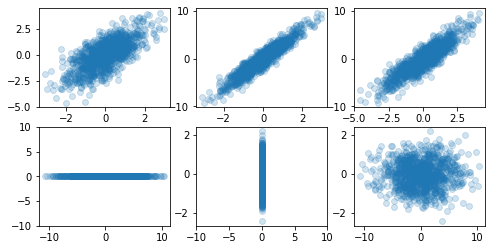

In [14]:
#* Redefine the data in the basis yielded by the PCA procedure
#* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) projections.

Xp = np.dot(df_gaus, V_gaus)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 4))

axes[0,0].scatter(df_gaus.iloc[:,0], df_gaus.iloc[:,1], alpha = 0.2)
axes[0,1].scatter(df_gaus.iloc[:,0], df_gaus.iloc[:,2], alpha = 0.2)
axes[0,2].scatter(df_gaus.iloc[:,1], df_gaus.iloc[:,2], alpha = 0.2)
axes[1,0].scatter(Xp[:,0], Xp[:,1], alpha = 0.2)
axes[1,0].set_ylim(-10,10)
axes[1,1].scatter(Xp[:,1], Xp[:,2], alpha = 0.2)
axes[1,1].set_xlim(-10,10)
axes[1,2].scatter(Xp[:,0], Xp[:,2], alpha = 0.2)

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [16]:
# Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

df_noise = df_gaus.copy()
for i in range(10):
    df_noise[str("Rumore" + str(i))] = pd.Series(np.random.randn(1000)*0.01+0.)
df_noise

,x1,x2,x3,Rumore0,Rumore1,Rumore2,Rumore3,Rumore4,Rumore5,Rumore6,Rumore7,Rumore8,Rumore9
0,-0.349657,1.171239,0.471925,-0.008020,0.008036,-0.009760,0.011700,-0.001201,0.005715,0.006356,-0.013206,-0.002885,-0.013643
1,1.581376,1.880519,5.043271,-0.011287,0.012986,0.006267,-0.011176,0.016541,-0.012085,0.004957,-0.003261,-0.000709,0.017165
2,-0.517222,-0.738448,-1.772891,-0.005217,-0.009032,0.003057,-0.011999,-0.018510,-0.001728,0.002498,0.014710,0.000886,0.001299
3,1.034524,0.631816,2.700864,-0.001651,0.006985,0.000793,-0.001854,0.009378,-0.008310,0.000201,-0.004621,0.018332,0.017263
4,1.130959,0.542270,2.804189,-0.001242,0.010489,-0.010131,-0.005147,-0.006194,0.018682,-0.006762,0.006824,0.019911,-0.003456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.276265,0.370260,0.922790,0.001165,-0.004398,-0.003665,-0.010293,-0.010291,0.001548,0.012584,0.000797,0.007322,-0.000684
996,-1.961261,-2.721285,-6.643807,-0.017751,0.011828,-0.008969,-0.000930,0.010782,-0.014051,-0.004970,0.007768,0.011369,-0.000275
997,0.334421,0.529923,1.198766,-0.009366,0.000191,0.005497,-0.011218,0.014875,0.005357,-0.015542,0.001598,0.002646,0.005958
998,-1.003595,-0.751616,-2.758806,-0.002737,0.002957,-0.013605,0.003286,0.007713,-0.002173,-0.013516,0.007344,0.010656,-0.009334


Ratio between eigenvalues and total sum: 
[9.61250401e-01 3.86709936e-02 4.62330244e-17 9.82841704e-06
 8.87205271e-06 6.56443163e-06 7.08330408e-06 7.12466516e-06
 7.38007286e-06 7.53747041e-06 7.92111780e-06 8.11742644e-06
 8.17639496e-06]
Ratio for the rotated dataframe. Of course this procedure yields the same values: 
[ 9.61250401e-01  3.86709936e-02 -8.78892352e-18  9.82841704e-06
  8.87205271e-06  6.56443163e-06  8.17639496e-06  8.11742644e-06
  7.92111780e-06  7.53747041e-06  7.38007286e-06  7.08330408e-06
  7.12466516e-06]
Again, the variables with a significative ratio are just two. The noise introduced has quite constant values and can be neglected.


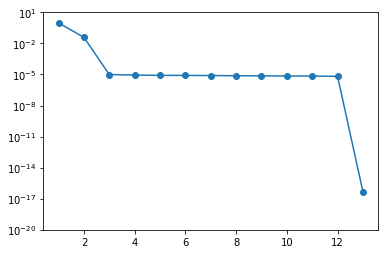

In [57]:
# Repeat the PCA procedure and compare the results with what you obtained before

a_noise = np.cov(df_noise.T)

l_noise, V_noise = la.eig(a_noise)

lam_noise=np.diag(l_noise)
print(f"Ratio between eigenvalues and total sum: \n{np.real_if_close(np.diag(lam_noise/lam_noise.trace()))}") 

df_rot = pd.DataFrame(np.dot(df_noise, V_noise))

l_rot, V_rot = la.eig(np.cov(df_rot.T))
print(f"Ratio for the rotated dataframe. Of course this procedure yields the same values: \n{np.real_if_close(l_rot/l_rot.sum())}")
print("Again, the variables with a significative ratio are just two. The noise introduced has quite constant values and can be neglected.")

l_noise[::-1].sort()
fig = plt.figure()
ax1 = fig.add_subplot(1,1,1)
ax1.plot(np.arange(len(l_noise))+1, np.real_if_close(l_noise/l_noise.sum()), '-o')
ax1.set_ylim(1e-20, 10)
ax1.set_yscale('log')
plt.show()

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


In [20]:
from scipy.spatial.transform import Rotation as R

In [22]:
N = 1000
df_spring = pd.DataFrame( index = np.arange(N), columns = ["x", "y", "z"])

df_spring["x"] = pd.Series(np.cos(np.linspace(0,6*np.pi, N)))
df_spring["y"] = pd.Series(np.random.randn(N)*0.01)
df_spring["z"] = pd.Series(np.zeros(N))

df_spring

,x,y,z
0,1.000000,0.004184,0.0
1,0.999822,-0.002682,0.0
2,0.999288,0.003836,0.0
3,0.998398,-0.011506,0.0
4,0.997153,0.001365,0.0
...,...,...,...
995,0.997153,0.008056,0.0
996,0.998398,-0.015284,0.0
997,0.999288,-0.003104,0.0
998,0.999822,0.005923,0.0


Ratio between eigenvalues of the covariance matrix and their sum:
[9.99804209e-01 1.95791426e-04 0.00000000e+00] 

The first component, as shown, contains 99,98% of the information.


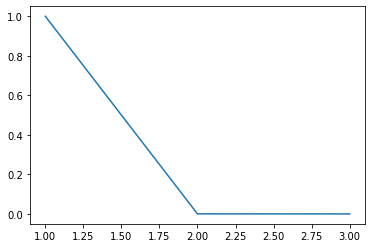

In [37]:
covM_spring = np.cov(df_spring.T)
l_spring,V_spring = la.eig(covM_spring)

df_rot = pd.DataFrame(np.dot(df_spring, np.real_if_close(V_spring.T)))

covM_rot=np.cov(df_rot.T)
l_rot, V_rot = la.eig(covM_rot)
    
lam2 = np.diag(l_rot)
print(f"Ratio between eigenvalues of the covariance matrix and their sum:\n{np.real_if_close(l_rot/l_rot.sum())} ")

print(f"\nThe first component, as shown, contains 99,98% of the information.")

fig_rot = plt.figure()
ax_rot = fig_rot.add_subplot(1,1,1)
ax_rot.plot(np.arange(len(l_rot))+1, np.real_if_close(l_rot/l_rot.sum()))
plt.show()

In [25]:
#Rotation of the original dataframe with some selected angles.
from scipy.spatial.transform import Rotation as R
angles = np.array( [ [90,0], [60,30], [30,60], [0,90]])

df_spring_modif = df_spring.copy()
for k in angles:
    theta = R.from_euler('x', k[0], degrees=True)
    phi   = R.from_euler('z', k[1], degrees=True)
    ang = theta*phi
    res = np.dot(df_spring,ang.as_matrix() )
    df_spring_modif[str("x"+str(k[0])+" "+str(k[1]))] = res[:,0]
    df_spring_modif[str("y"+str(k[0])+" "+str(k[1]))] = res[:,1]
    df_spring_modif[str("z"+str(k[0])+" "+str(k[1]))] = res[:,2]

df_spring_modif

,x,y,z,x90 0,y90 0,z90 0,x60 30,y60 30,z60 30,x30 60,y30 60,z30 60,x0 90,y0 90,z0 90
0,1.000000,0.004184,0.0,1.000000,9.290582e-19,-0.004184,0.867071,-0.498188,-0.003624,0.503138,-0.864214,-0.002092,0.004184,-1.000000,0.0
1,0.999822,-0.002682,0.0,0.999822,-5.955999e-19,0.002682,0.865201,-0.501072,0.002323,0.497899,-0.867033,0.001341,-0.002682,-0.999822,0.0
2,0.999288,0.003836,0.0,0.999288,8.518301e-19,-0.003836,0.866368,-0.497983,-0.003322,0.502521,-0.863748,-0.001918,0.003836,-0.999288,0.0
3,0.998398,-0.011506,0.0,0.998398,-2.554758e-18,0.011506,0.861762,-0.504181,0.009964,0.490570,-0.869620,0.005753,-0.011506,-0.998398,0.0
4,0.997153,0.001365,0.0,0.997153,3.030076e-19,-0.001365,0.863901,-0.497986,-0.001182,0.499600,-0.862969,-0.000682,0.001365,-0.997153,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.997153,0.008056,0.0,0.997153,1.788789e-18,-0.008056,0.865574,-0.495088,-0.006977,0.504619,-0.860072,-0.004028,0.008056,-0.997153,0.0
996,0.998398,-0.015284,0.0,0.998398,-3.393755e-18,0.015284,0.860817,-0.505817,0.013236,0.487736,-0.871257,0.007642,-0.015284,-0.998398,0.0
997,0.999288,-0.003104,0.0,0.999288,-6.892253e-19,0.003104,0.864633,-0.500988,0.002688,0.497316,-0.866753,0.001552,-0.003104,-0.999288,0.0
998,0.999822,0.005923,0.0,0.999822,1.315220e-18,-0.005923,0.867352,-0.497346,-0.005130,0.504353,-0.863306,-0.002962,0.005923,-0.999822,0.0


Ratio between eigenvalues and their sum: 
 [ 9.99804209e-01  1.95791426e-04  8.38412755e-17  1.80213788e-16
 -3.55926303e-17  7.86366355e-18 -2.36764731e-18  2.00805703e-21
  2.00805703e-21 -5.62750126e-21 -5.62750126e-21  1.87438668e-21
  7.75429637e-34  0.00000000e+00  0.00000000e+00]

There are only two (first and third) components that can be actually evaluated. The first one contains most part of the information. 



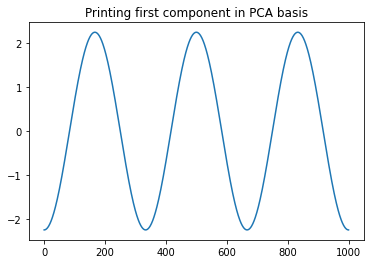

The first component in the rotated database is again a cosine, which reflects most part of the information. 
It can be also observed that the amplitude of the cosine changes with the number of angles choosen before. This is linked to the fact that every rotation adds to the pricipal component the same amount of information, and so it is why the cosine amplitude changes.

The previous results can be obtained in a couple of lines with sklearn: 
[9.99804209e-01 1.95791426e-04 3.60781702e-32 1.38787758e-33
 5.48883622e-34 2.69647347e-34 1.26145563e-34 2.84802287e-35
 1.75138071e-35 1.88118062e-37 1.37169494e-37 5.13298674e-38
 1.84243195e-60 3.30006432e-67 0.00000000e+00]

Note the logaritmic scale, and how fast the curve decreases to zero. Clearly, only the first couple of values can be considerated.


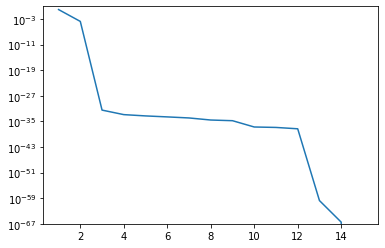

In [26]:
#PCA on rotated spring

covM_springrot = np.cov(df_spring_modif.T)

l_sprot, V_sprot = la.eig(covM_springrot)
l_sprot = np.real_if_close(l_sprot)

print(f"Ratio between eigenvalues and their sum: \n {l_sprot/l_sprot.sum()}\n")
print("There are only two (first and third) components that can be actually evaluated. The first one contains most part of the information. \n")

#rotation in PCA basis
df_spring_nb = pd.DataFrame(np.real_if_close(np.dot(df_spring_modif, V_sprot)))


plt.plot(df_spring_nb.iloc[:,0])
plt.title("Printing first component in PCA basis")
plt.show()
print("The first component in the rotated database is again a cosine, which reflects most part of the information. \nIt can be also observed that the amplitude of the cosine changes with the number of angles choosen before. This is linked to the fact that every rotation adds to the pricipal component the same amount of information, and so it is why the cosine amplitude changes.\n")

#same result with:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(df_spring_modif)
res = pca.explained_variance_ratio_
print(f"The previous results can be obtained in a couple of lines with sklearn: \n{res}\n")
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(len(res))+1, np.real_if_close(res/pca.explained_variance_ratio_.sum()))
ax.set_ylim(1e-67, 10)
ax.set_yscale("log")
print(f"Note the logaritmic scale, and how fast the curve decreases to zero. Clearly, only the first couple of values can be considerated.")
plt.show()

4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [27]:
# get the dataset and its description on the proper data directory
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

[4.40466498e-01 2.57987592e-01 1.34981328e-01 8.88172454e-02
 4.08498986e-02 2.90261107e-02 7.85438231e-03 1.04326075e-05
 5.77816391e-06 2.57395320e-08 7.09203170e-07]

Once more, most of the information is related to a first three/four features. In this way we are clearly able to reduce the size of our dataset. It would be also nice to see how a binary classification problem would perform whether we use the entire dataset or just the most relevant features.
The eigenvalues anyway have a more soft curve than the ones shown before. That is why, unlike in previous cases, we need to consider more than just one or two features to describe properly the information contained in the database.


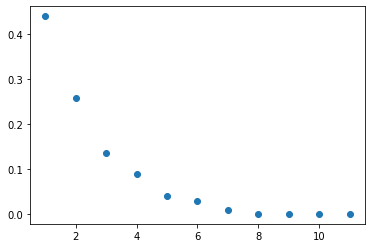

In [28]:
#again
filename = "/home/lorenzo/data/magic04.data"
descname = "/home/lorenzo/data/magic04.names"

index =  [  "fLength",      #continuous  # major axis of ellipse [mm]
            "fWidth",       #continuous  # minor axis of ellipse [mm] 
            "fSize",        #continuous  # 10-log of sum of content of all pixels [in #phot]
            "fConc",        #continuous  # ratio of sum of two highest pixels over fSize  [ratio]
            "fConc1",       #continuous  # ratio of highest pixel over fSize  [ratio]
            "fAsym",        #continuous  # distance from highest pixel to center, projected onto major axis [mm]
            "fM3Long",      #continuous  # 3rd root of third moment along major axis  [mm] 
            "fM3Trans",     #continuous  # 3rd root of third moment along minor axis  [mm]
            "fAlpha",       #continuous  # angle of major axis with vector to origin [deg]
            "fDist",        #continuous  # distance from origin to center of ellipse [mm]
            "classification"# g,h        # gamma (signal), hadron (background)
         ]  
# binary classification.. first idea Machine learing algorithm for classification. 

magic_df = pd.read_csv(filename, names = index)

dic = {'g': 1, 'h': 0}
magic_df['classification'] = magic_df['classification'].map(dic, na_action='ignore')

gamma_df = magic_df#[magic_df['classification']==1]  for focusing only on gammas

gamma_cov = np.cov(gamma_df.T)
l_cov, V_cov = la.eig(gamma_cov)

gammarot_df = pd.DataFrame(np.dot(gamma_df, np.real_if_close(V_cov.T)))

gammarot_cov=np.cov(gammarot_df.T)
l_rot, V_rot = la.eig(gammarot_cov)

res = np.diag(l_rot)
print(np.real_if_close(np.diag(res/res.trace())))

print("\nOnce more, most of the information is related to a first three/four features. In this way we are clearly able to reduce the size of our dataset. It would be also nice to see how a binary classification problem would perform whether we use the entire dataset or just the most relevant features.")
plt.scatter(np.arange(len(res))+1, np.real_if_close(np.diag(res/res.trace())))
print("The eigenvalues anyway have a more soft curve than the ones shown before. That is why, unlike in previous cases, we need to consider more than just one or two features to describe properly the information contained in the database.")